## SimplePDE

This is a tutorial of how to solve a simple PDE using PINNs.

PDE:  
$$\frac{\partial^2u}{\partial x^2}-\frac{\partial^4u}{\partial y^4}=(2-x^2)e^{-y}$$

Boundary Condition:  
$$u_{yy}(x,0)=x^2$$
$$u_{yy}(x,1)=\frac{x^2}{e}$$
$$u(x,0)=x^2$$
$$u(x,1)=\frac{x^2}{e}$$
$$u(0,y)=0$$
$$u(1,y)=e^{-y}$$

## 1. import python modules and setup random seeds

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def set_seeds(seeds):
    torch.manual_seed(seeds)
    torch.cuda.manual_seed(seeds)
    torch.backends.cudnn.deterministic = True

set_seeds(12)

g:\software\Anaconda\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. build nn model and define loss

In [2]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


## 3. loss function

In [3]:
# mean square loss
mse_loss = nn.MSELoss()


# gradient
def gradient(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
    else:
        return gradient(gradient(u, x), x, order-1)


def loss_interior(model, n, device):
    """
    (2-x^2)*e^(-y)
    """

    x = torch.rand(n, 1, requires_grad=True).to(device=device)
    y = torch.rand(n, 1, requires_grad=True).to(device=device)
    cond = (2 - x ** 2) * torch.exp(-y)
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(gradient(uxy, x, 2) - gradient(uxy, y, 4), cond)


def loss_uyy_down(model, n, device):
    """
    u_{yy}(x,0)=x^2
    """

    x = torch.randn(n, 1, requires_grad=True).to(device=device)
    y = torch.zeros_like(x, requires_grad=True).to(device=device)
    cond = x ** 2
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(gradient(uxy, y, 2), cond)


def loss_uyy_up(model, n, device):
    """
    u_{yy}(x,1)=x^2 / e
    """
    
    x = torch.randn(n, 1, requires_grad=True).to(device=device)
    y = torch.ones_like(x, requires_grad=True).to(device=device)
    cond = x ** 2 / torch.e
    uxy = model(torch.cat([x, y], dim=1))
    
    return mse_loss(gradient(uxy, y, 2), cond)


def loss_u_down(model, n, device):
    """
    u(x,0)=x^2
    """

    x = torch.randn(n, 1, requires_grad=True).to(device=device)
    y = torch.zeros_like(x, requires_grad=True).to(device=device)
    cond = x ** 2
    uxy = model(torch.cat([x, y], dim=1))
    
    return mse_loss(uxy, cond)


def loss_u_up(model, n, device):
    """
    u(x,1)=x^2 / e
    """
    
    x = torch.randn(n, 1, requires_grad=True).to(device=device)
    y = torch.ones_like(x, requires_grad=True).to(device=device)
    cond = x ** 2 / torch.e
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(uxy, cond)


def loss_u_left(model, n, device):
    """
    u(0,y)=0
    """
    
    y = torch.randn(n, 1, requires_grad=True).to(device=device)
    x = torch.zeros_like(y, requires_grad=True).to(device=device)
    cond = torch.zeros_like(x)
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(uxy, cond)


def loss_u_right(model, n, device):
    """
    u(1,y)=e^{-y}
    """
    
    y = torch.randn(n, 1, requires_grad=True).to(device=device)
    x = torch.ones_like(y, requires_grad=True).to(device=device)
    cond = torch.exp(-y)
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(uxy, cond)


def loss_data(model, n, device):
    x = torch.rand(n, 1, requires_grad=True).to(device=device)
    y = torch.rand(n, 1, requires_grad=True).to(device=device)
    cond = (x ** 2) * torch.exp(-y)
    uxy = model(torch.cat([x, y], dim=1))

    return mse_loss(uxy, cond)

## 4. training

In [4]:
# set training parameters
num_epochs = 2000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

n_interior = 1000 # 内点配点数
n_boundary = 1000 # 边界点配点数
n_pde = 1000 # PDE配点数

# record loss
loss_list = []
best_loss = 1.0E10

# training
model = MLP().to(device=device)
optimizer = torch.optim.Adam(params=model.parameters())

for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss =  loss_interior(model, n_interior, device) + loss_uyy_down(model, n_boundary, device) + \
            loss_uyy_up(model, n_boundary, device) + loss_u_down(model, n_boundary, device) + \
            loss_u_up(model, n_boundary, device) + loss_u_left(model, n_boundary, device) + \
            loss_u_right(model, n_boundary, device) # + loss_data(model, n_pde, device)
    loss.backward()
    
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: ", epoch, " loss: ", loss.item())

    # save model
    loss_list.append(loss.item()) # record loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best.pth")


Epoch:  0  loss:  23.828777313232422
Epoch:  100  loss:  8.849225044250488
Epoch:  200  loss:  1.4267849922180176
Epoch:  300  loss:  0.9503496885299683
Epoch:  400  loss:  0.8662524223327637
Epoch:  500  loss:  0.3084588944911957
Epoch:  600  loss:  0.6230151057243347
Epoch:  700  loss:  0.10736775398254395
Epoch:  800  loss:  0.17652583122253418
Epoch:  900  loss:  0.42793452739715576
Epoch:  1000  loss:  0.029196923598647118
Epoch:  1100  loss:  0.03866497427225113
Epoch:  1200  loss:  0.027931980788707733
Epoch:  1300  loss:  0.10351090133190155
Epoch:  1400  loss:  0.035745684057474136
Epoch:  1500  loss:  0.021424539387226105
Epoch:  1600  loss:  0.021951694041490555
Epoch:  1700  loss:  0.00916936807334423
Epoch:  1800  loss:  0.004616475664079189
Epoch:  1900  loss:  0.008748164400458336


## 5. inference and visualization

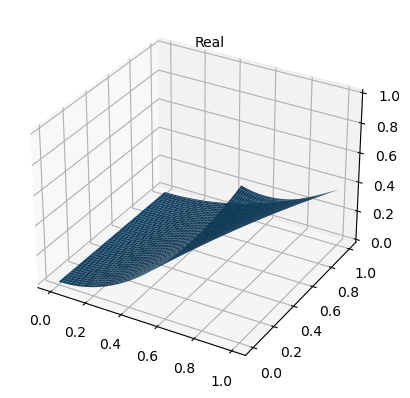

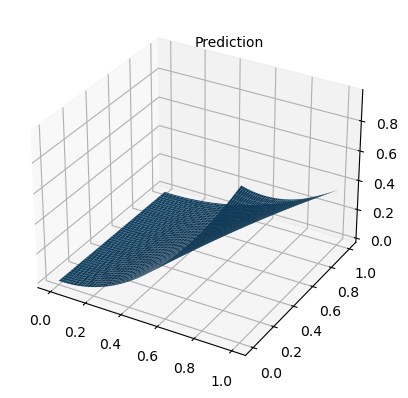

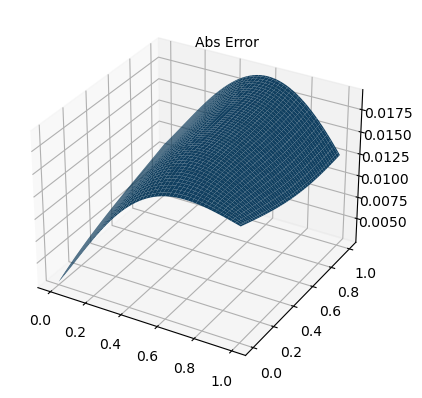

In [22]:
# mesh
n_mesh = 100 # 画图网格密度

xc = torch.linspace(0, 1, n_mesh)
xm, ym = torch.meshgrid(xc, xc)
xx = xm.reshape(-1, 1)
yy = ym.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)

# load model
model = MLP()
model.load_state_dict(torch.load("best.pth"))

# prediction
u_pred = model(xy)
u_real = xx * xx * torch.exp(-yy)
u_error = torch.abs(u_pred - u_real)

# visualization
u_pred_fig = u_pred.reshape(n_mesh, n_mesh)
u_real_fig = u_real.reshape(n_mesh, n_mesh)
u_error_fig = u_error.reshape(n_mesh, n_mesh)

# plot
fig1 = plt.figure(1)
# ax1 = Axes3D(fig1, auto_add_to_figure=False)
ax1 = fig1.add_subplot(projection='3d')
ax1.plot_surface(xm.detach().numpy(), ym.detach().numpy(), u_real_fig.detach().numpy())
ax1.text2D(0.5, 0.9, "Real", transform=ax1.transAxes)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(projection='3d')
ax2.plot_surface(xm.detach().numpy(), ym.detach().numpy(), u_pred_fig.detach().numpy())
ax2.text2D(0.5, 0.9, "Prediction", transform=ax2.transAxes)

fig3 = plt.figure(3)
ax3 = fig3.add_subplot(projection='3d')
ax3.plot_surface(xm.detach().numpy(), ym.detach().numpy(), u_error_fig.detach().numpy())
ax3.text2D(0.5, 0.9, "Abs Error", transform=ax3.transAxes)
plt.show()


## References

[1] https://www.bilibili.com/video/BV1MP41187M3/?share_source=copy_web&vd_source=ac61c95531df6011c6660e9f78d47740  
[2] [使用Axes3D时，出现Figure size 640x480 with 0 Axes](https://blog.csdn.net/weixin_52075272/article/details/133880393)